Hasan F. Durkaya - 504241526

Importing Necessasry Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

Hyperparameters and seed for reproducibility.

In [2]:
# Set random seed for reproducibility.
torch.manual_seed(42)

# Hyperparameters.
EPOCHS = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.001
LATENT_DIM = 64
INPUT_DIM = 28 * 28

### Architecture:

- Encoder: The encoder reduces the data step-by-step, "input_dim → 512 → 256 → latent_dim" Uses ReLU activation after each layer to capture complex patterns.
- The encoder’s output is a compressed representation of the input, "Latent Vector". Vector is the compressed summary fo input.
- Decoder: The decoder expands the latent vector back to the original size, latent_dim → 256 → 512 → input_dim. Uses Sigmoid activation at the last layer to keep the output between 0 and 1.
- Autoencoder: Encoder compresses the input into the latent vector. Decoder reconstructs the input from the latent vector. Learn to recreate the input as accurately as possible.
    
    Input → Encoder → Latent Vector → Decoder → Reconstructed Output

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
            nn.Sigmoid()  
        )
        
    def forward(self, x):
        return self.decoder(x)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction

### Data
- Preparing data in a format suitable for training/testing.
- Automating batch management and randomization for improved training performance.
- Returns two `DataLoader` objects:
  - `train_loader`: Provides batched training data.
  - `test_loader`: Provides batched test data.

In [4]:
#Function to get the data.
def load_data():
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    # Training and test datasets.
    train_dataset = datasets.FashionMNIST(
        root='./data', 
        train=True,
        download=True,
        transform=transform
    )
    
    test_dataset = datasets.FashionMNIST(
        root='./data', 
        train=False,
        download=True,
        transform=transform
    )
    
    #Data loaders.
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    
    return train_loader, test_loader

### Training

This function trains autoencoder model using the provided training and testing data.
- Device Setup.
- Training
    - Train Loss tracking.
    - Validation Loss tracking.  
- Minimizing the reconstruction error (difference between input and output).
- Monitoring performance on both training and validation datasets.

In [5]:
#Function to train the model.
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs):
    
    #Set the model to training mode. Device is set to GPU if available.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    train_losses = []
    test_losses = []
    
    # Training.
    for epoch in range(epochs):
        
        model.train()
        train_loss = 0
        
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view(data.size(0), -1).to(device)
            optimizer.zero_grad()
            reconstruction = model(data)
            loss = criterion(reconstruction, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        #Validation.
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, _ in test_loader:
                data = data.view(data.size(0), -1).to(device)
                reconstruction = model(data)
                loss = criterion(reconstruction, data)
                test_loss += loss.item()
                
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.6f}, Validation Loss: {test_loss:.6f}')
    
    return train_losses, test_losses

### Visualizaiton of test.
- Visually comparing the input images with their reconstructions.
- Evaluating the quality of the autoencoder's reconstruction visually.

In [6]:
def visualize_reconstruction(model, test_loader, num_images=20):
    
    #Set the model to evaluation mode. Device is set to GPU if available.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data[:num_images]
        data = data.view(data.size(0), -1).to(device)
        reconstruction = model(data)
        
        #Convert to numpy for visualization.
        data = data.cpu().view(-1, 28, 28)
        reconstruction = reconstruction.cpu().view(-1, 28, 28)
        
        plt.figure(figsize=(20, 4))
        for i in range(num_images):
            #riginal images.
            plt.subplot(2, num_images, i + 1)
            plt.imshow(data[i], cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title('Original Images')
                
            #Reconstructed images.
            plt.subplot(2, num_images, i + num_images + 1)
            plt.imshow(reconstruction[i], cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title('Reconstructed Images')
        
        plt.tight_layout()
        plt.show()

### Sampling
- The autoencoder generating new data points by sampling from its latent space.
- The potential for creating novel images that resemble the dataset it was trained on.

In [7]:
def generate_samples(model, num_samples=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    with torch.no_grad():
        # Generate random latent vectors
        latent_samples = torch.randn(num_samples, LATENT_DIM).to(device)
        
        # Generate images using the decoder
        generated = model.decoder(latent_samples)
        generated = generated.cpu().view(-1, 28, 28)
        
        plt.figure(figsize=(20, 2))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(generated[i], cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title('Generated Images')
                
        plt.tight_layout()
        plt.show()

### Main
- function that combines everything.

In [8]:
def main():
    #Data Loading.
    train_loader, test_loader = load_data()
    
    #Model, criterion and optimizer.
    model = Autoencoder(INPUT_DIM, LATENT_DIM)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    #Training the model.
    train_losses, test_losses = train_model(
        model, train_loader, test_loader, criterion, optimizer, EPOCHS
    )
    
    #Plotting training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()
    
    #Visualizing reconstructions
    visualize_reconstruction(model, test_loader)
    
    #Generating new samples
    generate_samples(model)

Epoch: 1, Train Loss: 0.035171, Validation Loss: 0.022236
Epoch: 2, Train Loss: 0.019843, Validation Loss: 0.017946
Epoch: 3, Train Loss: 0.016794, Validation Loss: 0.015855
Epoch: 4, Train Loss: 0.015093, Validation Loss: 0.014907
Epoch: 5, Train Loss: 0.013747, Validation Loss: 0.013312
Epoch: 6, Train Loss: 0.012779, Validation Loss: 0.012734
Epoch: 7, Train Loss: 0.012125, Validation Loss: 0.011847
Epoch: 8, Train Loss: 0.011542, Validation Loss: 0.011447
Epoch: 9, Train Loss: 0.011053, Validation Loss: 0.010971
Epoch: 10, Train Loss: 0.010676, Validation Loss: 0.010657
Epoch: 11, Train Loss: 0.010317, Validation Loss: 0.010600
Epoch: 12, Train Loss: 0.009995, Validation Loss: 0.010007
Epoch: 13, Train Loss: 0.009752, Validation Loss: 0.009834
Epoch: 14, Train Loss: 0.009496, Validation Loss: 0.009634
Epoch: 15, Train Loss: 0.009301, Validation Loss: 0.009369
Epoch: 16, Train Loss: 0.009090, Validation Loss: 0.009215
Epoch: 17, Train Loss: 0.008908, Validation Loss: 0.009152
Epoch:

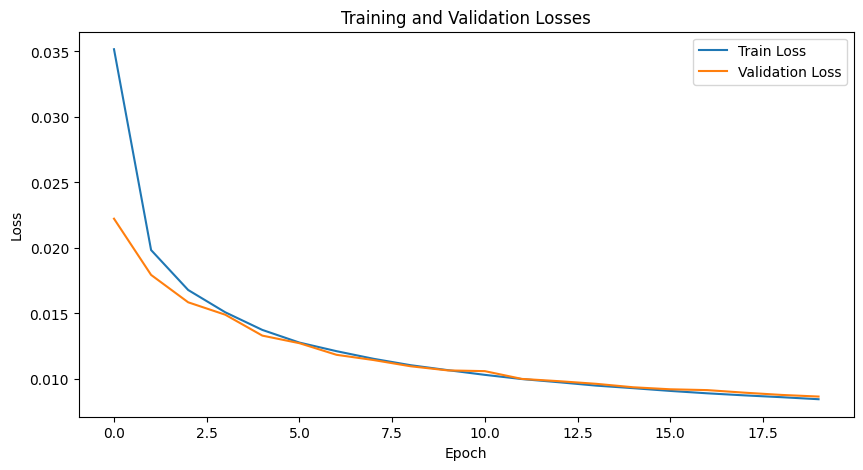

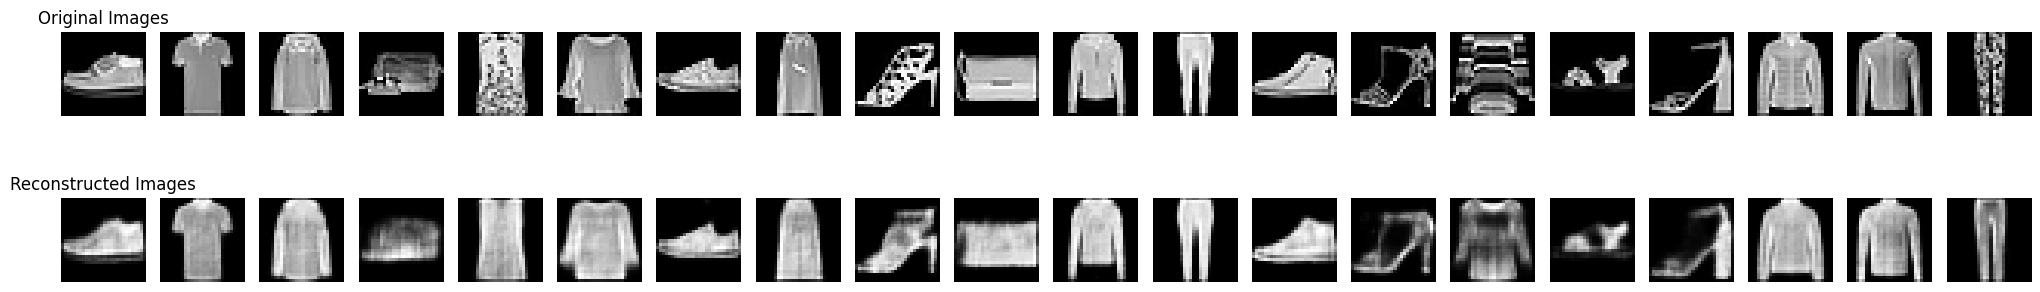

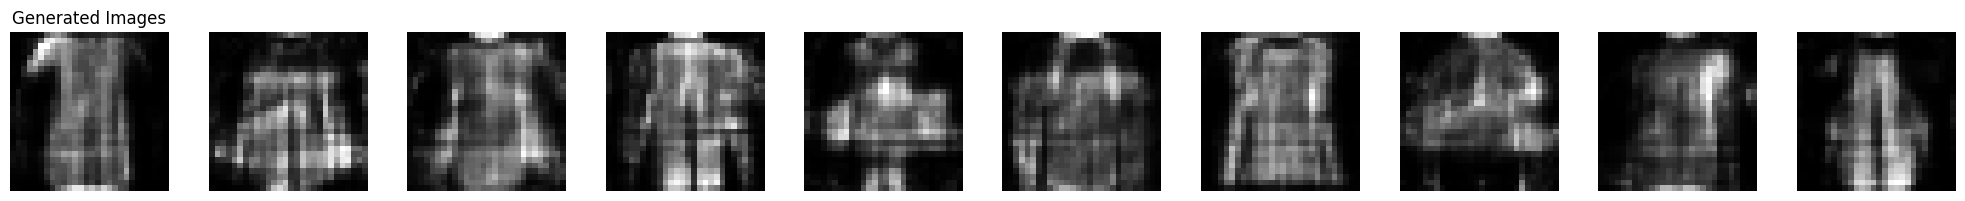

In [9]:
if __name__ == "__main__":
    main()
    